# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.gp8 # use or create a database named demo
tweet_collection = db.tweet_collection #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [9]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [10]:
track = ['COVID19'] # define the keywords, tweets contain election

#locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [11]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

AttributeError: module 'tweepy' has no attribute 'StreamListener'

## Use the REST API to Collect Tweets

Authorize the REST API 

In [37]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [38]:
count = 100 #number of returned tweets, default and max is 100
geocode = "44.3148,-85.6024,200mi"  # defin the location, in Harrisonburg, VA
q = "COVID19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [39]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [41]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [42]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

1479
736


Create a text index and print the Tweets containing specific keywords. 

In [26]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [27]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "COVID19"}}) # return tweets contain vote

Use pprint to display tweets

In [28]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Kathleen 🌍💨🔥
text: Benton County Arkansas lost this deputy to #COVID19  There are more deaths by #COVID19 than any other cause for 2 y… https://t.co/GsGedNpzDC
----
name: BIconnections
text: The COVID19 package, an interface to the COVID-19 #Data Hub
The COVID19 package, an interface to the COVID-19 #Data… https://t.co/gW2tgBbavi
----
name: Nikhil Meena
text: @ChristophHutchi Cannot like this .
Boo #covid19
----
name: Leader2light
text: @fxmacro Early Covid19 is mild for everyone.
----
name: Sweet Home Allegra
text: #COVID19 https://t.co/4GwORJhUI4
----
name: Beverly
text: #COVID19 https://t.co/RbuO8qn40f
----
name: Mikel Morgan
text: @USATRUMPMAN1 Said that since #COVID19 BS started
----
name: MVM
text: #Covidisme 
#COVID19 https://t.co/H8YAwych6D
----
name: Marie Estelle Spike
text: https://t.co/xPlgoZzIsp #vaccine #COVID19
----
name: Les Guessing
text: #vax #COVID19 https://t.co/5IUjs4K402


In [29]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "COVID19"}}) # return tweets contain vote

Use pandas to display tweets

In [30]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status
0,61a699e47b4313071e6d64f8,Mon Nov 29 02:58:47 +0000 2021,1465153236248285190,1465153236248285190,Benton County Arkansas lost this deputy to #CO...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,...,1,1,False,False,False,en,NaN,NaN,NaN,NaN
1,61b637e37390e37c921acf67,Sat Dec 11 06:23:18 +0000 2021,1469553359480832000,1469553359480832000,"The COVID19 package, an interface to the COVID...",True,"{'hashtags': [{'text': 'Data', 'indices': [50,...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,0,False,False,False,en,NaN,NaN,NaN,NaN
2,61a699e47b4313071e6d64e7,Mon Nov 29 18:26:09 +0000 2021,1465386614604148738,1465386614604148738,@ChristophHutchi Cannot like this .\nBoo #covid19,False,"{'hashtags': [{'text': 'covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.465373e+18,...,0,1,False,False,NaN,en,NaN,NaN,NaN,NaN
3,61b637ed7390e37c921ad0c5,Sat Dec 04 15:28:27 +0000 2021,1467153834514558982,1467153834514558982,@fxmacro Early Covid19 is mild for everyone.,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.467154e+18,...,0,1,False,False,NaN,en,NaN,NaN,NaN,NaN
4,61b637ed7390e37c921ad0b5,Sat Dec 04 23:56:06 +0000 2021,1467281588660670464,1467281588660670464,#COVID19 https://t.co/4GwORJhUI4,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1,2,False,False,False,und,"{'media': [{'id': 1467281581232513024, 'id_str...",NaN,NaN,NaN
5,61b637ed7390e37c921ad0a4,Sun Dec 05 16:35:38 +0000 2021,1467533129028091912,1467533129028091912,#COVID19 https://t.co/RbuO8qn40f,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,0,False,False,False,und,NaN,1.467533e+18,1467532856670969859,{'created_at': 'Sun Dec 05 16:34:33 +0000 2021...
6,61b637ed7390e37c921ad0a2,Sun Dec 05 17:03:41 +0000 2021,1467540188901613576,1467540188901613576,@USATRUMPMAN1 Said that since #COVID19 BS started,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.467355e+18,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
7,61b637ec7390e37c921ad06b,Mon Dec 06 18:54:58 +0000 2021,1467930583393312770,1467930583393312770,#Covidisme \n#COVID19 https://t.co/H8YAwych6D,False,"{'hashtags': [{'text': 'Covidisme', 'indices':...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,0,False,False,False,und,"{'media': [{'id': 1467930578766995461, 'id_str...",NaN,NaN,NaN
8,61b637ea7390e37c921ad016,Wed Dec 08 00:23:53 +0000 2021,1468375743486910465,1468375743486910465,https://t.co/xPlgoZzIsp #vaccine #COVID19,False,"{'hashtags': [{'text': 'vaccine', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,0,False,False,False,und,NaN,NaN,NaN,NaN
9,61b637e87390e37c921acfa3,Fri Dec 10 02:33:49 +0000 2021,1469133219010392070,1469133219010392070,#vax #COVID19 https://t.co/5IUjs4K402,False,"{'hashtags': [{'text': 'vax', 'indices': [0, 4...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,0,False,False,False,und,"{'media': [{'id': 146913291702054502

<AxesSubplot:>

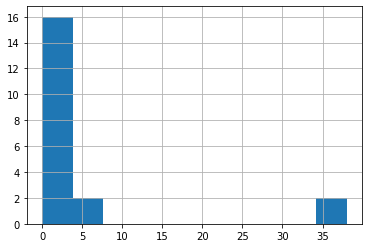

In [22]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count